<a href="https://colab.research.google.com/github/DCODE-ARMY/GAN/blob/main/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install wget

In [2]:
import os
import numpy as np
import pickle
import requests
import matplotlib.pyplot as plt
import wget
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
from tensorflow import keras


In [3]:
def load_coursework_data():
    import wget
    path_to_check = os.path.join('', 'image_recognition_dataset.pth')
    if not os.path.exists(path_to_check):
        print("Cannot find the dataset on local !")
        print("Downloading the dataset from cloud, it may take several mintues.")
        url = 'https://www.dropbox.com/s/j05hyf667ikzu4s/image_recognition_dataset.pth?dl=1'
        filename = wget.download(url)
        data_path = os.path.join('', filename)
    else:
        print("Data founded on local {:s}".format(path_to_check))
        data_path = path_to_check
        
    data = pickle.load(open(data_path, 'rb'))
    train_imgs,train_labels,test_imgs,test_labels = data.values()
    return train_imgs,train_labels,test_imgs,test_labels

In [4]:
x,y,test_imgs,test_labels = load_coursework_data()
validation_x,validation_y=x[:5000],y[:5000]
validation_x=validation_x*(1./255)

train_imgs=x[5000:]
train_imgs=train_imgs*(1./255)
train_labels=y[5000:]

#converting labels to one hot
train_labels=np.squeeze(tf.one_hot(train_labels,depth=8))

validation_y=np.squeeze(tf.one_hot(validation_y,depth=8))
test_labels=np.squeeze(tf.one_hot(test_labels,depth=8))

Data founded on local image_recognition_dataset.pth


In [5]:
# # train_labels1=tf.one_hot(train_labels,depth=8)
# # train_labels1[:4]
# train_labels.shape
# np.squeeze(train_labels).shape

In [6]:
cls_train = len(np.unique(y))
print("Total number of image classes : {:d}".format(cls_train))
print("Shape of training set", train_imgs.shape)

print("Training image count: ", train_imgs.shape[0])
print("Test image count: ", test_imgs.shape[0])

Total number of image classes : 8
Shape of training set (35000, 32, 32, 3)
Training image count:  35000
Test image count:  8000


In [7]:
# train_dataset=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,zoom_range=0.2,shear_range=0.2,
#                                                               rotation_range=0.2)


In [8]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_imgs,train_labels))
train_dataset=train_dataset.shuffle(buffer_size=64).batch(batch_size=64)

validation_dataset=tf.data.Dataset.from_tensor_slices((validation_x,validation_y))
validation_dataset=validation_dataset.shuffle(buffer_size=64).batch(batch_size=64)


test_dataset=tf.data.Dataset.from_tensor_slices((test_imgs,test_labels))
test_dataset=test_dataset.shuffle(buffer_size=64).batch(batch_size=64)



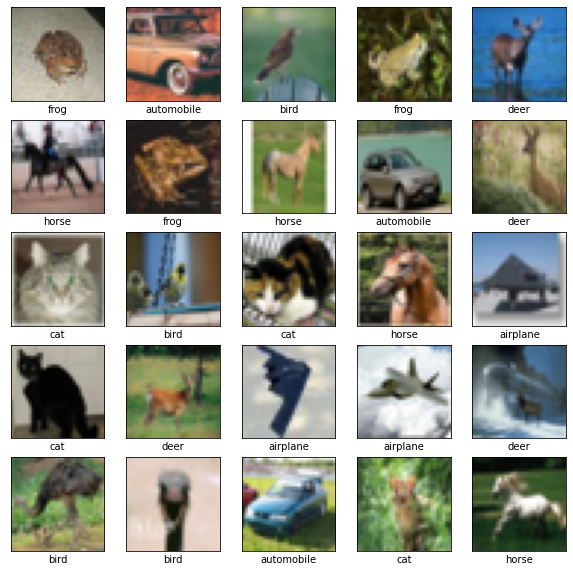

In [9]:
import matplotlib.pyplot as plt
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_imgs[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y[5000:][i][0]])
plt.show()

In [10]:
image_size=32
channel_axis=3

In [11]:
def model():
    inp =layers.Input(shape=[image_size, image_size,channel_axis])
    # inp =layers.Rescaling(1./255)(inp)
    # inp =layers.RandomFlip('horizontal')(inp)
    # inp =layers.RandomRotation(0.2)(inp)
    
    #branch 1
    x=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(inp)
    
    branch1x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    # branch1x1=layers.BatchNormalization()(branch1x1)
    
    branch2x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch2x2=layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch2x1)
    # branch2x2=layers.BatchNormalization()(branch2x2)

    branch3x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch3x2=layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch3x1)
    branch3x3=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x2)
    # branch3x3=layers.BatchNormalization()(branch3x3)
    
    maxpool1x1=layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branch4x1=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(maxpool1x1)
    # branch4x1=layers.BatchNormalization()(branch4x1)
    
    x=layers.concatenate([branch1x1,branch2x2,branch3x3,branch4x1],axis=channel_axis)
    
    x=layers.Dropout(0.1)(x)
    
    #branch 2
    branch1x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch1x1=layers.BatchNormalization()(branch1x1)
    
    branch2x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch2x2=layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch2x1)
    # branch2x2=layers.BatchNormalization()(branch2x2)
    
    branch3x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch3x2=layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch3x1)
    branch3x3=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x2)
    # branch3x3=layers.BatchNormalization()(branch3x3)
    
    maxpool1x1=layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branch4x1=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(maxpool1x1)
    # branch4x1=layers.BatchNormalization()(branch4x1)
    
    x=layers.concatenate([branch1x1,branch2x2,branch3x3,branch4x1],axis=channel_axis)
    
    x=layers.Dropout(0.1)(x)
    
    #downsampling 1
    x=layers.Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.BatchNormalization()(x)
    
    #branch 3
    branch1x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    # branch1x1=layers.BatchNormalization()(branch1x1)
    
    branch2x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch2x2=layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch2x1)
    # branch2x2=layers.BatchNormalization()(branch2x2)
    
    branch3x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch3x2=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x1)
    branch3x3=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x2)
    # branch3x3=layers.BatchNormalization()(branch3x3)
    
    maxpool1x1=layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branch4x1=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(maxpool1x1)
    # branch4x1=layers.BatchNormalization()(branch4x1)
    
    x=layers.concatenate([branch1x1,branch2x2,branch3x3,branch4x1],axis=channel_axis)
    
    x=layers.Dropout(0.1)(x)
    
    #branch 4
    branch1x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    # branch1x1=layers.BatchNormalization()(branch1x1)
    
    branch2x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch2x2=layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch2x1)
    # branch2x2=layers.BatchNormalization()(branch2x2)
    
    branch3x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch3x2=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x1)
    branch3x3=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x2)
    # branch3x3=layers.BatchNormalization()(branch3x3)
    
    maxpool1x1=layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branch4x1=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(maxpool1x1)
    # branch4x1=layers.BatchNormalization()(branch4x1)
    
    x=layers.concatenate([branch1x1,branch2x2,branch3x3,branch4x1],axis=channel_axis)
    
    x=layers.Dropout(0.1)(x)
    
#     #downsampling 2
    x=layers.Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
    x=layers.Conv2D(filters=64,kernel_size=(5,5),strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.BatchNormalization()(x)
    
    #branch 5
    branch1x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    # branch1x1=layers.BatchNormalization()(branch1x1)
    
    branch2x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch2x2=layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation='relu')(branch2x1)
    # branch2x2=layers.BatchNormalization()(branch2x2)
    
    branch3x1=layers.Conv2D(filters=64,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    branch3x2=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x1)
    branch3x3=layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),padding='same',activation='relu')(branch3x2)
    # branch3x3=layers.BatchNormalization()(branch3x3)
    
    maxpool1x1=layers.MaxPool2D(pool_size=(3,3),strides=(1,1),padding='same')(x)
    branch4x1=layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(maxpool1x1)
    # branch4x1=layers.BatchNormalization()(branch4x1)
    
    x=layers.concatenate([branch1x1,branch2x2,branch3x3,branch4x1],axis=channel_axis)
    # x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    
    x=layers.Conv2D(filters=128,kernel_size=1,strides=(1,1),padding='same',activation='relu')(x)
    # x=layers.BatchNormalization()(x)
    
    x=layers.Conv2D(filters=128,kernel_size=3,strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.1)(x)
    
    x=layers.Conv2D(filters=128,kernel_size=3,strides=(2,2),padding='valid',activation='relu')(x)
    # x=layers.BatchNormalization()(x)
    
    
    # x=layers.Conv2D(filters=128,kernel_size=3,strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.Dropout(0.4)(x)
    
    # x=layers.Conv2D(filters=128,kernel_size=2,strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.Dropout(0.4)(x)
    
    # x=layers.Conv2D(filters=128,kernel_size=2,strides=(2,2),padding='same',activation='relu')(x)
    # x=layers.Dropout(0.4)(x)
    
    
    
    x=layers.Flatten()(x)
    
    x=layers.Dense(units=1024,kernel_regularizer=tf.keras.regularizers.L2(0.01),
                  )(x) # activity_regularizer=tf.keras.regularizers.L2(0.01)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    x=layers.Dropout(0.4)(x)

    # x=layers.Dense(units=512,kernel_regularizer=tf.keras.regularizers.L2(0.01),
    #                )(x)  #activity_regularizer=tf.keras.regularizers.L2(0.01)
    # x=layers.BatchNormalization()(x)
    # x=layers.ReLU()(x)
    # x=layers.Dropout(0.4)(x)
    
    # x=layers.Dense(units=256,kernel_regularizer=tf.keras.regularizers.L2(0.01),
    #               )(x)  # activity_regularizer=tf.keras.regularizers.L2(0.01)
    # x=layers.BatchNormalization()(x)
    # x=layers.ReLU()(x)
    # x=layers.Dropout(0.4)(x)
    
    x=layers.Dense(units=8,activation='softmax')(x)
    # x=layers.Softmax()(x)
    
    return keras.Model(inputs=[inp],outputs=x)
    
    
    
    
    

In [12]:
model=model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   4864        ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 32, 32, 64)   4160        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 64)   4160        ['conv2d[0][0]']                 
                                                                                              

In [13]:
learning_rate=0.05

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



In [14]:

checkpoint_dir = '/content/drive/MyDrive/MLproject/chk'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

csv_logger=tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/MLProject/log.csv', separator=",", append=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)


model.fit(
    train_dataset,
    epochs=1000,
    validation_steps=60,
    validation_data=validation_dataset,
    callbacks=[csv_logger,
        checkpoint_callback,],
)

Epoch 1/1000
547/547 [==============================] - ETA: 0s - loss: 9.0439 - accuracy: 0.1366

547/547 [==============================] - 93s 152ms/step - loss: 9.0439 - accuracy: 0.1366 - val_loss: nan - val_accuracy: 0.1250
Epoch 2/1000
 72/547 [==>...........................] - ETA: 1:00 - loss: 34.4787 - accuracy: 0.1230

KeyboardInterrupt: ignored

In [ ]:
"""
case1:
  only model without softmax and from logits=true no regularization or batchnorm  was used
  lr=0.05 
  op:
  acc and val acc remains on 0.12.. and val_loss was nan

case 2:
  added batchNorm to each branch
  added regularization to dense layers
  op
  accuracy increased to 50 and remained close to it 

case 3:
  changed sparse to categorical 
  added dropout to ddense layers 
  chaged regularizers to L2
  added one more dense layer with 1024 units 

"""